In [2]:
# Probabilistic PCA in Pymc3

In [3]:
# Bayesian PCA in PyMC3 based on http://edwardlib.org/tutorials/probabilistic-pca

In [20]:
import os
import sys
import time

In [21]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
theano.config.exception_verbosity = 'high'
os.environ["MKL_THREADING_LAYER"]="GNU"

In [24]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on numpy: v1.18.1
Running on theano: v1.0.4
Running on PYMC3: v3.8


In [25]:
%matplotlib inline

Probabilistic principal components analysis (PCA) is a dimensionality reduction technique that analyzes data via a lower dimensional latent space (Tipping & Bishop, 1999). It is often used when there are missing values in the data or for multidimensional scaling.

# Data

We use simulated data. We'll talk about the individual variables and what they stand for in the next section. For this example, each data point is 2-dimensional, xn∈ℝ2.

In [10]:
def build_toy_dataset(N, D, K, sigma=1):
    x_train = np.zeros((D, N))
    w = np.random.normal(0.0, 2.0, size=(D, K))
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    for d in range(D):
        for n in range(N):
            x_train[d, n] = np.random.normal(mean[d, n], sigma)

    print("True principal axes:")
    print(w)
    return x_train

N = 5000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

x_train = build_toy_dataset(N, D, K)


True principal axes:
[[2.97586494]
 [1.09993655]]


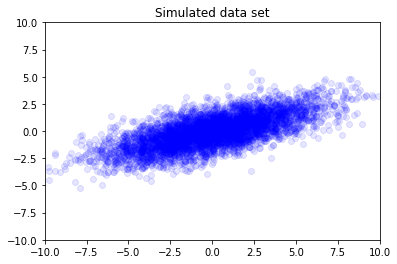

In [11]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

# Model

Consider a data set X={xn} of N data points, where each data point is D-dimensional, xn∈ℝD. We aim to represent each xn under a latent variable zn∈ℝK with lower dimension, K<D. The set of principal axes W

relates the latent variables to the data.

Specifically, we assume that each latent variable is normally distributed,
zn∼N(0,I).

The corresponding data point is generated via a projection,
xn∣zn∼N(Wzn,σ2I),

where the matrix W∈ℝD×K
are known as the principal axes. In probabilistic PCA, we are typically interested in estimating the principal axes W and the noise term σ2

.

Probabilistic PCA generalizes classical PCA. Marginalizing out the the latent variable, the distribution of each data point is
xn∼N(0,WWT+σ2I).

Classical PCA is the specific case of probabilistic PCA when the covariance of the noise becomes infinitesimally small, σ2→0

.

We set up our model below. In our analysis, we fix σ=2.0
, and instead of point estimating W as a model parameter, we place a prior over it in order to infer a distribution over principal axes.

# Inference¶

The posterior distribution over the principal axes W cannot be analytically determined. Below, we set up our inference variables and then run a chosen algorithm to infer W.

In [12]:
with pm.Model() as PPCA:
    w = pm.Normal('w', mu=tt.zeros([D, K]), sd=2.0 * tt.ones([D, K]), shape=[D, K])
    z = pm.Normal('z', mu=tt.zeros([N, K]), sd=tt.ones([N, K]), shape=[N, K])
    x = pm.Normal('x', mu=w.dot(z.T), sd=tt.ones([D, N]), shape=[D, N], observed=x_train)  

    trace = pm.sample(draws=2000, tune=2000))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z, w]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:22<00:00, 89.49draws/s] 


In [13]:
print(trace.varnames)

['w', 'z']


In [29]:
trace['w'].shape, trace['z'].shape

((1000, 2, 1), (1000, 5000, 1))

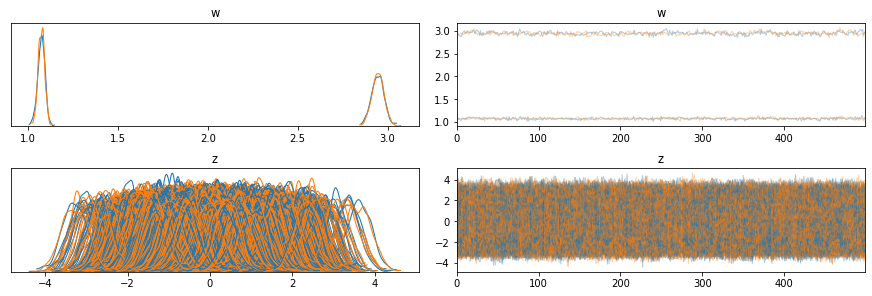

In [26]:
pm.traceplot(trace)
plt.show()

In [167]:
w=np.asarray(trace.get_values('w', burn=0, combine=True))
z=np.asarray(trace.get_values('z', burn=0, combine=True))

In [168]:
w.shape, z.shape

((1000, 2, 1), (1000, 5000, 1))

In [169]:
w_est=np.mean(w, axis=0)
z_est=np.mean(z, axis=0)

In [170]:
w_est.shape, z_est.shape

((2, 1), (5000, 1))

In [171]:
print("Inferred principal axes:")
print(w_est)

Inferred principal axes:
[[2.94572902]
 [1.07517129]]


In [172]:
z_est.mean()

-0.007525630520544863

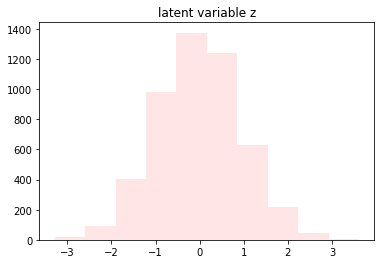

In [173]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(z_est, color='r', alpha=0.1)
#plt.axis([-10, 10, -10, 10])
plt.title("latent variable z")
plt.show()

In [174]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, samples=200, model=PPCA)

100%|██████████| 200/200 [00:00<00:00, 408.01it/s]


In [175]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

x => [[[-0.29571207  1.51926865 -0.73943989 ...  1.4411235   2.69204376
   -1.94329796]
  [-0.45802318  1.76361777  0.31953148 ...  1.82670056  2.30347706
    0.65381855]]

 [[-0.12003302 -1.79659777 -0.36801983 ...  4.00810046  3.76844701
    2.53887262]
  [ 1.36426416 -1.08296221  0.95227641 ...  2.27462653  0.92103253
    1.03136315]]

 [[-0.44791064  1.87772284 -0.97670734 ...  0.87660359 -0.45883066
   -0.5397509 ]
  [ 0.19611247  0.48551907 -0.41998695 ...  0.36336405 -1.04754833
    0.4252004 ]]

 ...

 [[-0.33589313  0.32071824 -0.16295258 ...  2.73208503  1.85769933
   -0.29066639]
  [ 0.51055559  2.68136488  0.56876057 ...  0.19951518  0.57342707
    0.40691753]]

 [[ 1.85107673 -2.29747179 -1.02556078 ...  1.81682419  0.31878033
   -0.11054265]
  [-1.26420339  1.82404047 -1.14639446 ...  1.39378174  0.22760271
    0.64510489]]

 [[-1.05632623  1.91828102 -0.36789844 ...  2.3823695   1.40479939
    1.74964088]
  [ 1.55307108  0.91722669 -2.05153962 ...  3.18988868 -1.24392555

In [176]:
x_gen=ppc_trace['x']

In [177]:
x_train.shape, x_gen.shape

((2, 5000), (200, 2, 5000))

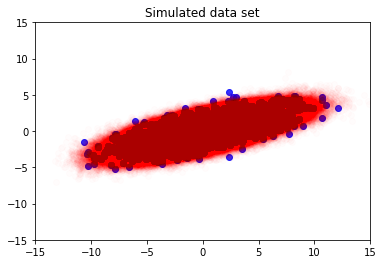

In [178]:
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.8)
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01)
plt.axis([-15, 15, -15, 15])
plt.title("Simulated data set")
plt.show()

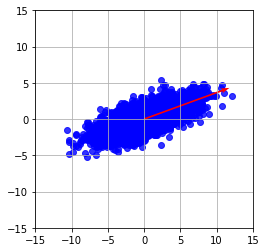

In [166]:
X = np.array((0))
Y= np.array((0))
U = w_est[0]
V = w_est[1]

fig, ax = plt.subplots()
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.8)
q = ax.quiver(X, Y, U, V,units='xy' ,scale=.25, color='r')
plt.grid()
ax.set_aspect('equal')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

In [116]:
ppc_5=np.percentile(x_gen, [50], axis=0)
ppc_95=np.percentile(x_gen, [97.5], axis=0)

In [117]:
ppc_5.shape

(1, 2, 5000)

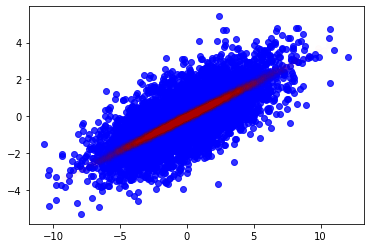

In [156]:
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.8)
plt.scatter(ppc_5[0,0,:], ppc_5[0,1,:], color='r', alpha=0.01)
plt.show()